<a href="https://colab.research.google.com/github/KirpaDmitriy/Systems/blob/main/Kirpa_FSM_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1 "Синтез управляющего конечного автомата"
## Кирпа Дмитрий, P33211

### Задание

Требуется спроектировать конечный автомат, управляющий стиральной машиной.

Стиральная машина работает в трех режимах: залив, стирка, слив. Машина начинает работать по нажатию кнопки «Пуск».
После этого происходит залив воды до тех пор, пока датчик d1 уровня воды не подаст сигнал о заполнения бака стиральной машины. Затем происходит стирка.
Эта операция ограничивается с помощью таймера t.

Если таймер исправен, то по истечении определенного времени он выдает сигнал о завершении стирки и стиральная машина переходит в режим слива воды. Если таймер неисправен, то стиральная машина переходит в состояние «дефект», т.е. в состояние ожидания, которое может быть прервано только после ремонта стиральной машины.

Из состояния «дефект» стиральная машина не может возвратиться в исходное состояние, поэтому последующее нажатие кнопки «Пуск» не приведет к запуску стиральной машины.

Из неисправного состояния после ремонта стиральная машина возвращается в исходное состояние по сигналу reset. Слив воды завершается при получении сигнала от датчика d2 уровня воды о том, что в баке воды нет. После этого стиральная машина возвращается в исходное состояние.


### Реализация

In [ ]:
!pip install python-statemachine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Другие интересные библиотеки:
<ul>
  <li>https://github.com/alysivji/finite-state-machine</li>
</ul>

In [ ]:
from statemachine import StateMachine, State

In [ ]:
class MoydodirAvtomat(StateMachine):
    # состояния
    newState = State("исходное состояние", initial = True)
    runnableState = State("залив")
    onCPUState = State("стирка")
    timerInterruptedState = State("слив")
    errorInterruptedState = State("дефект")
    fixedState = State("починена")
      
    # переходы
    switchPusk = newState.to(runnableState)  # пуск: из готовой -> залив
    switchD1Interrupt = runnableState.to(onCPUState)  # прерывание d1: из залива -> на CPU
    switchTimerInterrupt = onCPUState.to(timerInterruptedState)  # прерывание по таймеру: из CPU -> на слив
    switchBrokenInterrupt = onCPUState.to(errorInterruptedState)  # прерывание по ошибке: из CPU -> в дефект
    switchD2Interrupt = timerInterruptedState.to(newState)  # прерывание d2: из слива -> выключаем
    switchFix = errorInterruptedState.to(fixedState)  # починка: из ломаной -> починеная
    switchReset = fixedState.to(newState)  # починка: починеная -> к бою готова

moydodir = MoydodirAvtomat()
print(moydodir.current_state.name)

исходное состояние


In [ ]:
class Sensor():
    def __init__(self, threshold: float):
        self.threshold = threshold
    
    @property
    def sensor_type(self) -> str:
        raise NotImplementedError()
    
    def check(self, *args, **kwargs) -> bool:
        raise NotImplementedError()
    
    def __repr__(self) -> str:
        return f'Датчик "{self.sensor_type}" с порогом {self.threshold}\n'

class OverSensor(Sensor):
    @property
    def sensor_type(self) -> str:
        return 'больше чем'
    
    def check(self, level: float) -> bool:
        return level > self.threshold

class UnderSensor(Sensor):
    @property
    def sensor_type(self) -> str:
        return 'меньше или равно'
    
    def check(self, level: float) -> bool:
        return level <= self.threshold


MAX_CAPACITY = 100
ZERO_LEVEL = 0

d1 = OverSensor(MAX_CAPACITY)
d2 = UnderSensor(ZERO_LEVEL)

d1, d2

(Датчик "больше чем" с порогом 100, Датчик "меньше или равно" с порогом 0)

In [ ]:
class Button(Sensor):
    def __init__(self):
        super().__init__(True)
        self.level = False
    
    @property
    def sensor_type(self) -> str:
        return 'button'
    
    def press(self):
        self.level = True
    
    def check(self, *args, **kwargs) -> bool:
        if self.level == self.threshold:
            self.level = False
            return True
        return False

pusk = Button()
reset = Button()
pusk, reset

(Датчик "button" с порогом True, Датчик "button" с порогом True)

In [ ]:
class Moydodir:
    def __init__(self, max_capacity: int = MAX_CAPACITY, min_capacity: int = ZERO_LEVEL, init_water_level: float = 0, is_timer_broken: bool = False, wash_time: float = 5, water_per_tick: float = 25):
        self.core = MoydodirAvtomat()
        self.d1 = OverSensor(max_capacity)
        self.d2 = UnderSensor(min_capacity)
        self.pusk_button = Button()
        self.reset_button = Button()
        self.timer = OverSensor(wash_time)
        self.water_level = init_water_level
        self.water_per_tick = water_per_tick
        self.is_timer_broken = is_timer_broken
    
    def run(self, max_tick:int = 50, verbose: bool = True):
        tick = 0
        trace = []
        while tick < max_tick:
            current_state = self.core.current_state.name
            if verbose:
                print(f'Сейчас я в состоянии "{current_state}"')
            
            if current_state == 'исходное состояние':
                pusk = input('Жмякнуть пуск? ')
                if pusk.lower() in ['ага', 'да', 'yes', 'yeah', '+']:
                    self.pusk_button.press()
                if self.pusk_button.check():
                    if verbose:
                        print('Запускаю залив!')
                    self.core.switchPusk()
            if current_state == 'залив':
                if not self.d1.check(self.water_level):
                    self.water_level += self.water_per_tick
                    if verbose:
                        print(f'Залила воды на {self.water_level}!')
                else:
                    if verbose:
                        print('Запускаю стирку!')
                    self.core.switchD1Interrupt()
            if current_state == 'стирка':
                if self.is_timer_broken:
                    if verbose:
                        print('УУУУПС!!! Счастливые стиралки таймеров не наблюдают')
                    self.core.switchBrokenInterrupt()
                else:
                    if self.timer.check(tick):
                        if verbose:
                            print('Стирка окончена')
                        self.core.switchTimerInterrupt()
                    elif verbose:
                        print('Стирка в процессе')
            if current_state == 'слив':
                if not self.d2.check(self.water_level):
                    self.water_level -= self.water_per_tick
                    if verbose:
                        print(f'Вылила воды на {self.water_level}!')
                else:
                    if verbose:
                        print('Конец стирки!')
                    self.core.switchD2Interrupt()
            if current_state == 'дефект':
                fix = input('Починить? ')
                if fix.lower() in ['ага', 'да', 'yes', 'yeah', '+']:
                    if verbose:
                        print('Чиню!')
                    self.core.switchFix()
                    self.is_timer_broken = False
            if current_state == 'починена':
                reset = input('Жмякнуть reset? ')
                if reset.lower() in ['ага', 'да', 'yes', 'yeah', '+']:
                    if verbose:
                        print('Завожу машину!')
                    self.core.switchReset()
            
            trace.append(current_state)
            tick += 1

In [ ]:
# Проверка свойств
moydodir.is_newState, moydodir.is_runnableState, moydodir.is_onCPUState

(True, False, False)

In [ ]:
[s.identifier for s in moydodir.states]

['errorInterruptedState',
 'fixedState',
 'newState',
 'onCPUState',
 'runnableState',
 'timerInterruptedState']

In [ ]:
[tr.identifier for tr in moydodir.transitions]

['switchBrokenInterrupt',
 'switchD1Interrupt',
 'switchD2Interrupt',
 'switchFix',
 'switchPusk',
 'switchReset',
 'switchTimerInterrupt']

In [ ]:
super_moydodir = Moydodir()
super_moydodir.run()

Сейчас я в состоянии "исходное состояние"
Жмякнуть пуск? +
Запускаю залив!
Сейчас я в состоянии "залив"
Залила воды на 25!
Сейчас я в состоянии "залив"
Залила воды на 50!
Сейчас я в состоянии "залив"
Залила воды на 75!
Сейчас я в состоянии "залив"
Залила воды на 100!
Сейчас я в состоянии "залив"
Залила воды на 125!
Сейчас я в состоянии "залив"
Запускаю стирку!
Сейчас я в состоянии "стирка"
Стирка окончена
Сейчас я в состоянии "слив"
Вылила воды на 100!
Сейчас я в состоянии "слив"
Вылила воды на 75!
Сейчас я в состоянии "слив"
Вылила воды на 50!
Сейчас я в состоянии "слив"
Вылила воды на 25!
Сейчас я в состоянии "слив"
Вылила воды на 0!
Сейчас я в состоянии "слив"
Конец стирки!
Сейчас я в состоянии "исходное состояние"
Жмякнуть пуск? +
Запускаю залив!
Сейчас я в состоянии "залив"
Залила воды на 25!
Сейчас я в состоянии "залив"
Залила воды на 50!
Сейчас я в состоянии "залив"
Залила воды на 75!
Сейчас я в состоянии "залив"
Залила воды на 100!
Сейчас я в состоянии "залив"
Залила воды на 12

In [ ]:
broken_moydodir = Moydodir(is_timer_broken=True)
broken_moydodir.run()

Сейчас я в состоянии "исходное состояние"
Жмякнуть пуск? -
Сейчас я в состоянии "исходное состояние"
Жмякнуть пуск? +
Запускаю залив!
Сейчас я в состоянии "залив"
Залила воды на 25!
Сейчас я в состоянии "залив"
Залила воды на 50!
Сейчас я в состоянии "залив"
Залила воды на 75!
Сейчас я в состоянии "залив"
Залила воды на 100!
Сейчас я в состоянии "залив"
Залила воды на 125!
Сейчас я в состоянии "залив"
Запускаю стирку!
Сейчас я в состоянии "стирка"
УУУУПС!!! Счастливые стиралки таймеров не наблюдают
Сейчас я в состоянии "дефект"
Починить? +
Чиню!
Сейчас я в состоянии "починена"
Жмякнуть reset? +
Завожу машину!
Сейчас я в состоянии "исходное состояние"
Жмякнуть пуск? +
Запускаю залив!
Сейчас я в состоянии "залив"
Запускаю стирку!
Сейчас я в состоянии "стирка"
Стирка окончена
Сейчас я в состоянии "слив"
Вылила воды на 100!
Сейчас я в состоянии "слив"
Вылила воды на 75!
Сейчас я в состоянии "слив"
Вылила воды на 50!
Сейчас я в состоянии "слив"
Вылила воды на 25!
Сейчас я в состоянии "слив"

### Диаграммы переходов

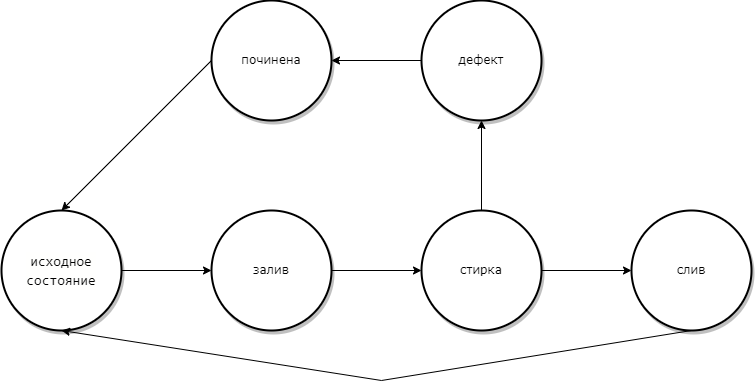